In [1]:
import torch
import pickle
import numpy as np
import copy
import random

from torch import nn
from torchvision import models, transforms
import torchvision

import pandas as pd

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_extractor = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(128, 256, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),
        )

        self.task1_classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(256, 100)
        )

    def forward(self, x):
        hidden = self.cnn_extractor(x)
        hidden = hidden.flatten(1)
        task1_predictions = self.task1_classifier(hidden)
        
        return task1_predictions


class TwoTaskCNN(CNN):
    def __init__(self):
        super().__init__()
        self.task2_classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(128, 20)
        )

    def forward(self, x):
        hidden = self.cnn_extractor(x)
        hidden = hidden.flatten(1)
        task1_predictions = self.task1_classifier(hidden)
        task2_predictions = self.task2_classifier(hidden)
        
        return task1_predictions, task2_predictions


class ThreeTaskCNN(TwoTaskCNN):
    def __init__(self):
        super().__init__()
        self.task3_classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(128, 10)
        )

    def forward(self, x):
        hidden = self.cnn_extractor(x)
        hidden = hidden.flatten(1)
        task1_predictions = self.task1_classifier(hidden)
        task2_predictions = self.task2_classifier(hidden)
        task3_predictions = self.task3_classifier(hidden)

        
        return task1_predictions, task2_predictions, task3_predictions


class FourTaskCNN(ThreeTaskCNN):
    def __init__(self):
        super().__init__()
        self.task4_classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(128, 5)
        )

    def forward(self, x):
        hidden = self.cnn_extractor(x)
        hidden = hidden.flatten(1)
        task1_predictions = self.task1_classifier(hidden)
        task2_predictions = self.task2_classifier(hidden)
        task3_predictions = self.task3_classifier(hidden)
        task4_predictions = self.task4_classifier(hidden)
        
        return task1_predictions, task2_predictions, task3_predictions, task4_predictions


class FiveTaskCNN(FourTaskCNN):
    def __init__(self):
        super().__init__()
        self.task5_classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(128, 2)
        )

    def forward(self, x):
        hidden = self.cnn_extractor(x)
        hidden = hidden.flatten(1)
        task1_predictions = self.task1_classifier(hidden)
        task2_predictions = self.task2_classifier(hidden)
        task3_predictions = self.task3_classifier(hidden)
        task4_predictions = self.task4_classifier(hidden)
        task5_predictions = self.task5_classifier(hidden)
        
        return task1_predictions, task2_predictions, task3_predictions, task4_predictions, task5_predictions

In [39]:
class CIFAR100_random_partition(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        with open(path, 'rb') as f:
            packed_data = pickle.load(f, encoding='bytes')

        self.data = packed_data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        self.fine_labels = packed_data[b'fine_labels']

        # 2-fold partition
        part_lst = [i for i in range(100)]
        random.seed(0)
        random.shuffle(part_lst)
        
        step=100//2
        trans_dict = {}     
        for new_label, lower in enumerate(range(0, 100, step)):
            for old_label in part_lst[lower:lower+step]:
                trans_dict[old_label] = new_label
        self.labels_2fold = [trans_dict[label] for label in self.fine_labels]

        # 5-fold partition
        '''
        part_lst = [i for i in range(100)]
        random.seed(1)
        random.shuffle(part_lst)
        '''
        step=100//5
        trans_dict = {}     
        for new_label, lower in enumerate(range(0, 100, step)):
            for old_label in part_lst[lower:lower+step]:
                trans_dict[old_label] = new_label
        self.labels_5fold = [trans_dict[label] for label in self.fine_labels]
        
        # 10-fold partition
        '''
        part_lst = [i for i in range(100)]
        random.seed(2)
        random.shuffle(part_lst)
        '''
        step=100//10
        trans_dict = {}     
        for new_label, lower in enumerate(range(0, 100, step)):
            for old_label in part_lst[lower:lower+step]:
                trans_dict[old_label] = new_label
        self.labels_10fold = [trans_dict[label] for label in self.fine_labels]

        # 20-fold partition
        '''
        part_lst = [i for i in range(100)]
        random.seed(3)
        random.shuffle(part_lst)
        '''

        step=100//20
        trans_dict = {}     
        for new_label, lower in enumerate(range(0, 100, step)):
            for old_label in part_lst[lower:lower+step]:
                trans_dict[old_label] = new_label
        self.labels_20fold = [trans_dict[label] for label in self.fine_labels]
              
        if transform is None:
            self.transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
                    ])
        else:
            self.transform = transforms.Compose([
                    transform,
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
                    ])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]

        label_2fold = self.labels_2fold[idx]
        label_5fold = self.labels_5fold[idx]
        label_10fold = self.labels_10fold[idx]
        label_20fold = self.labels_20fold[idx]


        fine_label = self.fine_labels[idx]

        tensor = self.transform(img)

        return tensor, fine_label, label_20fold, label_10fold, label_5fold, label_2fold


class CoarserCIFAR100(CIFAR100):
    def __init__(self, path, transform=None):
        with open(path, 'rb') as f:
            packed_data = pickle.load(f, encoding='bytes')

        self.data = packed_data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        self.coarse_labels = packed_data[b'coarse_labels']
        self.fine_labels = packed_data[b'fine_labels']
        if transform is None:
            self.transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
                    ])
        else:
            self.transform = transforms.Compose([
                    transform,
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
                    ])
        # make more general classes
        coarser_dict = {1:0, 15:0, 7:0, 13:0, 3:1, 5:1, 6:1, 9:2, 18:2, 19:2, 10:2, 2:3, 4:3, 17:3, 8:4, 16:4, 11:4, 12:4, 14:4, 0:4}

        self.coarser_labels = [coarser_dict[label] for label in self.coarse_labels]
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]

        coarser_label = self.coarser_labels[idx]
        coarse_label = self.coarse_labels[idx]
        fine_label = self.fine_labels[idx]

        tensor = self.transform(img)
        #print('ТАрвгыпагыо')
        return tensor, fine_label, coarse_label, coarser_label 

In [40]:
def plot_results(df_train_metrics_tasks, df_val_metrics_tasks):
    task_num = len(df_train_metrics_tasks.columns)//2
    # plot metrics
    fig, axs = plt.subplots(task_num, 2, figsize=(15, 10))

    for task in range(task_num):
        if task==0:
            axs[0, 0].set_title('Losses')
        
        axs[task, 0].plot(df_train_metrics_tasks['Task{} Loss'.format(task+1)])
        axs[task, 0].plot(df_val_metrics_tasks['Task{} Loss'.format(task+1)])
        axs[task, 0].set_ylabel('Task{}'.format(task+1))

    for task in range(task_num):
        if task==0:
            axs[0, 1].set_title('Accuraces')
        
        axs[task, 1].plot(df_train_metrics_tasks['Task{} Acc'.format(task+1)])
        axs[task, 1].plot(df_val_metrics_tasks['Task{} Acc'.format(task+1)])
        axs[task, 1].set_ylabel('Task{}'.format(task+1))

def print_val_metrics(df_val_metrics_tasks):
    task_num = len(df_val_metrics_tasks.columns)//2
    for task in range(task_num):
        task_str = 'Task{}'.format(task+1)
        print(
            'Max {} acc: {} on epoch #{}'.format(
                task_str,
                df_val_metrics_tasks['{} Acc'.format(task_str)].max(),
                df_val_metrics_tasks['{} Acc'.format(task_str)].argmax())
            )
        print(
            'Min {} loss: {} on epoch #{}'.format(
                task_str,
                df_val_metrics_tasks['{} Loss'.format(task_str)].min(),
                df_val_metrics_tasks['{} Loss'.format(task_str)].argmin())
            )
        print()

In [41]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.8, 1.2), shear=10)
])

cifar_train = CIFAR100_random_partition(path='cifar-100-python/train', transform=transform)
cifar_test = CIFAR100_random_partition(path='cifar-100-python/test')

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=256, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=256, shuffle=False, num_workers=0)

# TASK1

In [42]:
device = torch.device('cuda:0')

cnn = CNN()
cnn = cnn.to(device)
optimizer = torch.optim.Adam(cnn.parameters())
criterion = nn.CrossEntropyLoss()

epoch_num = 200

In [43]:
# train task 1
def train_step(engine, batch):
    cnn.train()
    optimizer.zero_grad()
    images = batch[0].to(device)
    task1_labels = batch[1].to(device)
    # forward propagation
    task1_pred = cnn(images)
    
    # loss computations
    task1_loss = criterion(task1_pred, task1_labels)

    # backpropagation
    task1_loss.backward()
    optimizer.step()

    return task1_pred, task1_labels

def eval_step(engine, batch):
    cnn.eval()
    with torch.no_grad():
        images = batch[0].to(device)
        task1_labels = batch[1].to(device)
        task1_pred = cnn(images)

    return task1_pred, task1_labels

# dataframes with logs
train_metrics_list = []
val_metrics_list = []

trainer = Engine(train_step)
validator = Engine(eval_step)

Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(trainer, 'Task1 Acc')
Loss(criterion, output_transform=lambda x: [x[0], x[1]]).attach(trainer, 'Task1 Loss')

Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(validator, 'Task1 Acc')
Loss(criterion, output_transform=lambda x: [x[0], x[1]]).attach(validator, 'Task1 Loss')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    print('##############################################')
    print('# Epoch {} completed in {:.2f} s'.format(engine.state.epoch, engine.state.times['EPOCH_COMPLETED']))
    
    val_metrics = validator.run(test_loader).metrics
    train_metrics = engine.state.metrics
    
    print('# Training task1 loss: {}'.format(train_metrics['Task1 Loss']))
    print('# Training task1 acc: {}'.format(train_metrics['Task1 Acc']))
    print('#')
    print('# Validation task1 loss: {}'.format(val_metrics['Task1 Loss']))
    print('# Validation task1 acc: {}'.format(val_metrics['Task1 Acc']))

    # save logs
    train_metrics_list.append(copy.deepcopy(train_metrics))
    val_metrics_list.append(copy.deepcopy(val_metrics))

In [44]:
output = trainer.run(data=train_loader, max_epochs=200)

ining task1 loss: 0.9679520946502685
# Training task1 acc: 0.73502
#
# Validation task1 loss: 1.5851539012908935
# Validation task1 acc: 0.6196
##############################################
# Epoch 114 completed in 31.07 s
# Training task1 loss: 0.9756060256004333
# Training task1 acc: 0.73302
#
# Validation task1 loss: 1.5909770740509033
# Validation task1 acc: 0.6148
##############################################
# Epoch 115 completed in 29.72 s
# Training task1 loss: 0.9603034642982483
# Training task1 acc: 0.73792
#
# Validation task1 loss: 1.5609155975341797
# Validation task1 acc: 0.625
##############################################
# Epoch 116 completed in 29.75 s
# Training task1 loss: 0.9574119252777099
# Training task1 acc: 0.73788
#
# Validation task1 loss: 1.634858203125
# Validation task1 acc: 0.6122
##############################################
# Epoch 117 completed in 29.68 s
# Training task1 loss: 0.952826604423523
# Training task1 acc: 0.73888
#
# Validation task1 lo

Text(0, 0.5, 'Task1')

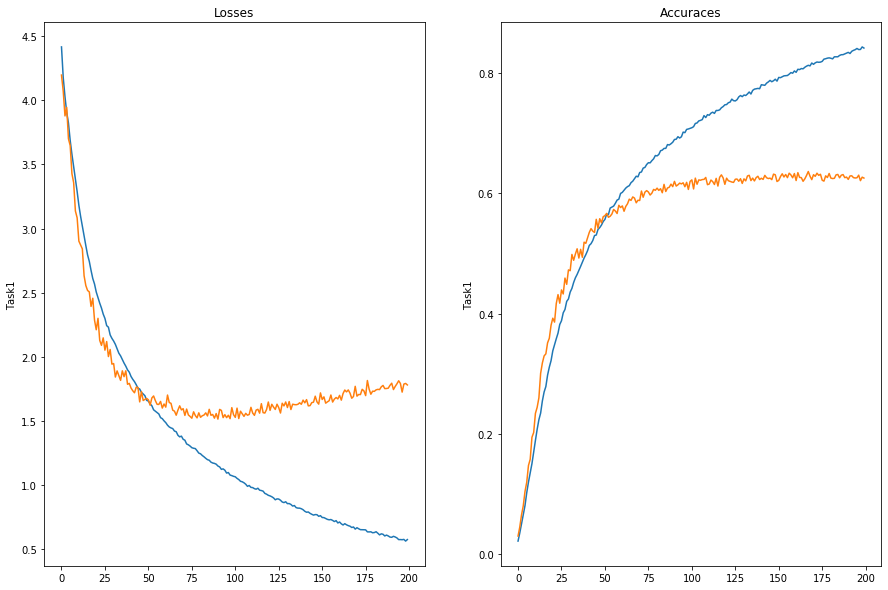

In [45]:
# make dataframe with metrics
train_metrics_task1 = pd.DataFrame(train_metrics_list)
val_metrics_task1 = pd.DataFrame(val_metrics_list)

train_metrics_task1.to_csv('train_metrics_task1.csv')
val_metrics_task1.to_csv('val_metrics_task1.csv')

# plot metrics
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

axs[0].set_title('Losses')
axs[0].plot(train_metrics_task1['Task1 Loss'].values)
axs[0].plot(val_metrics_task1['Task1 Loss'].values)
axs[0].set_ylabel('Task1')

axs[1].set_title('Accuraces')
axs[1].plot(train_metrics_task1['Task1 Acc'].values)
axs[1].plot(val_metrics_task1['Task1 Acc'].values)
axs[1].set_ylabel('Task1')

In [46]:
print('Max val acc: {} on epoch #{}'.format(val_metrics_task1['Task1 Acc'].max(), val_metrics_task1['Task1 Acc'].argmax()))
print('Min val loss: {} on epoch #{}'.format(val_metrics_task1['Task1 Loss'].min(), val_metrics_task1['Task1 Loss'].argmin()))

Max val acc: 0.6364 on epoch #167
Min val loss: 1.514425560760498 on epoch #90


# TASK2

In [47]:
device = torch.device('cuda:0')

cnn = TwoTaskCNN()
cnn = cnn.to(device)
optimizer = torch.optim.Adam(cnn.parameters())
criterion = nn.CrossEntropyLoss()

epoch_num = 200

In [48]:
# train task 2
def train_step(engine, batch):
    cnn.train()
    optimizer.zero_grad()
    images = batch[0].to(device)
    task1_labels = batch[1].to(device)
    task2_labels = batch[2].to(device)
    
    # forward propagation
    task1_pred, task2_pred = cnn(images)
    
    # loss computations
    task1_loss = criterion(task1_pred, task1_labels)
    task2_loss = criterion(task2_pred, task2_labels)

    total_task_loss = task1_loss + task2_loss

    # backpropagation
    total_task_loss.backward()
    optimizer.step()

    return task1_pred, task1_labels, task2_pred, task2_labels

def eval_step(engine, batch):
    cnn.eval()
    with torch.no_grad():
        images = batch[0].to(device)
        task1_labels = batch[1].to(device)
        task2_labels = batch[2].to(device)
        task1_pred, task2_pred = cnn(images)

    return task1_pred, task1_labels, task2_pred, task2_labels

# dataframes with logs
train_metrics_list = []
val_metrics_list = []

trainer = Engine(train_step)
validator = Engine(eval_step)

Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(trainer, 'Task1 Acc')
Accuracy(output_transform=lambda x: [x[2], x[3]]).attach(trainer, 'Task2 Acc')
Loss(criterion, output_transform=lambda x: [x[0], x[1]]).attach(trainer, 'Task1 Loss')
Loss(criterion, output_transform=lambda x: [x[2], x[3]]).attach(trainer, 'Task2 Loss')

Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(validator, 'Task1 Acc')
Accuracy(output_transform=lambda x: [x[2], x[3]]).attach(validator, 'Task2 Acc')
Loss(criterion, output_transform=lambda x: [x[0], x[1]]).attach(validator, 'Task1 Loss')
Loss(criterion, output_transform=lambda x: [x[2], x[3]]).attach(validator, 'Task2 Loss')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    print('##############################################')
    print('# Epoch {} completed in {:.2f} s'.format(engine.state.epoch, engine.state.times['EPOCH_COMPLETED']))
    
    val_metrics = validator.run(test_loader).metrics
    train_metrics = engine.state.metrics

    for key in train_metrics:
        print('# Training {}: {}'.format(key, train_metrics[key]))
    print('#')
    for key in train_metrics:
        print('# Vlaidation {}: {}'.format(key, val_metrics[key]))

    # save logs
    train_metrics_list.append(copy.deepcopy(train_metrics))
    val_metrics_list.append(copy.deepcopy(val_metrics))

In [49]:
output = trainer.run(data=train_loader, max_epochs=200)

sk1 Acc: 0.6298
# Vlaidation Task2 Acc: 0.6416
# Vlaidation Task1 Loss: 1.687494666671753
# Vlaidation Task2 Loss: 1.52885285987854
##############################################
# Epoch 148 completed in 32.34 s
# Training Task1 Acc: 0.80722
# Training Task2 Acc: 0.82538
# Training Task1 Loss: 0.7124706850242615
# Training Task2 Loss: 0.6131559106445312
#
# Vlaidation Task1 Acc: 0.6238
# Vlaidation Task2 Acc: 0.6394
# Vlaidation Task1 Loss: 1.6872642433166505
# Vlaidation Task2 Loss: 1.5072031536102295
##############################################
# Epoch 149 completed in 32.25 s
# Training Task1 Acc: 0.80776
# Training Task2 Acc: 0.82786
# Training Task1 Loss: 0.7100915439987182
# Training Task2 Loss: 0.6110461677932739
#
# Vlaidation Task1 Acc: 0.623
# Vlaidation Task2 Acc: 0.6363
# Vlaidation Task1 Loss: 1.7158507648468018
# Vlaidation Task2 Loss: 1.5393816059112548
##############################################
# Epoch 150 completed in 32.56 s
# Training Task1 Acc: 0.8086
# Traini

In [50]:
# make dataframe with metrics
train_metrics_task2 = pd.DataFrame(train_metrics_list)
val_metrics_task2 = pd.DataFrame(val_metrics_list)

train_metrics_task2.to_csv('train_metrics_task2.csv')
val_metrics_task2.to_csv('val_metrics_task2.csv')



Max Task1 acc: 0.6329 on epoch #199
Min Task1 loss: 1.5151706266403198 on epoch #82

Max Task2 acc: 0.6486 on epoch #115
Min Task2 loss: 1.3204267984390259 on epoch #82



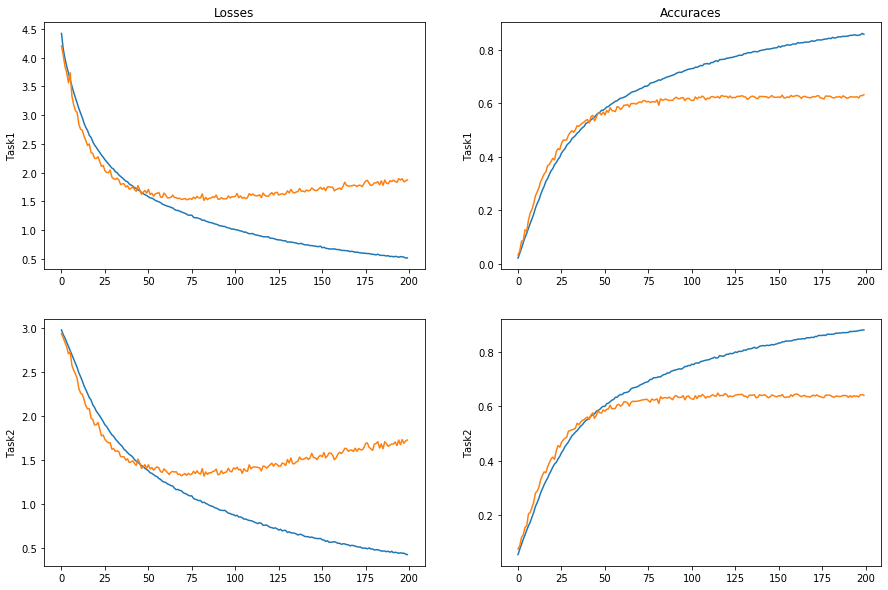

In [51]:
plot_results(train_metrics_task2, val_metrics_task2)
print_val_metrics(val_metrics_task2)

# TASK3

In [52]:
device = torch.device('cuda:0')

cnn = ThreeTaskCNN()
cnn = cnn.to(device)
optimizer = torch.optim.Adam(cnn.parameters())
criterion = nn.CrossEntropyLoss()

epoch_num = 200

In [53]:
# train task 3
def train_step(engine, batch):
    cnn.train()
    optimizer.zero_grad()
    images = batch[0].to(device)
    task1_labels = batch[1].to(device)
    task2_labels = batch[2].to(device)
    task3_labels = batch[3].to(device)
    
    # forward propagation
    task1_pred, task2_pred, task3_pred = cnn(images)
    
    # loss computations
    task1_loss = criterion(task1_pred, task1_labels)
    task2_loss = criterion(task2_pred, task2_labels)
    task3_loss = criterion(task3_pred, task3_labels)

    total_task_loss = task1_loss + task2_loss + task3_loss

    # backpropagation
    total_task_loss.backward()
    optimizer.step()

    return task1_pred, task1_labels, task2_pred, task2_labels, task3_pred, task3_labels

def eval_step(engine, batch):
    cnn.eval()
    with torch.no_grad():
        images = batch[0].to(device)
        task1_labels = batch[1].to(device)
        task2_labels = batch[2].to(device)
        task3_labels = batch[3].to(device)
        
        # forward propagation
        task1_pred, task2_pred, task3_pred = cnn(images)

    return task1_pred, task1_labels, task2_pred, task2_labels, task3_pred, task3_labels

# dataframes with logs
train_metrics_list = []
val_metrics_list = []

trainer = Engine(train_step)
validator = Engine(eval_step)

Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(trainer, 'Task1 Acc')
Accuracy(output_transform=lambda x: [x[2], x[3]]).attach(trainer, 'Task2 Acc')
Accuracy(output_transform=lambda x: [x[4], x[5]]).attach(trainer, 'Task3 Acc')
Loss(criterion, output_transform=lambda x: [x[0], x[1]]).attach(trainer, 'Task1 Loss')
Loss(criterion, output_transform=lambda x: [x[2], x[3]]).attach(trainer, 'Task2 Loss')
Loss(criterion, output_transform=lambda x: [x[4], x[5]]).attach(trainer, 'Task3 Loss')

Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(validator, 'Task1 Acc')
Accuracy(output_transform=lambda x: [x[2], x[3]]).attach(validator, 'Task2 Acc')
Accuracy(output_transform=lambda x: [x[4], x[5]]).attach(validator, 'Task3 Acc')
Loss(criterion, output_transform=lambda x: [x[0], x[1]]).attach(validator, 'Task1 Loss')
Loss(criterion, output_transform=lambda x: [x[2], x[3]]).attach(validator, 'Task2 Loss')
Loss(criterion, output_transform=lambda x: [x[4], x[5]]).attach(validator, 'Task3 Loss')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    print('##############################################')
    print('# Epoch {} completed in {:.2f} s'.format(engine.state.epoch, engine.state.times['EPOCH_COMPLETED']))
    
    val_metrics = validator.run(test_loader).metrics
    train_metrics = engine.state.metrics

    for key in train_metrics:
        print('# Training {}: {}'.format(key, train_metrics[key]))
    print('#')
    for key in train_metrics:
        print('# Vlaidation {}: {}'.format(key, val_metrics[key]))

    # save logs
    train_metrics_list.append(copy.deepcopy(train_metrics))
    val_metrics_list.append(copy.deepcopy(val_metrics))

In [54]:
output = trainer.run(data=train_loader, max_epochs=200)

cc: 0.6305
# Vlaidation Task3 Acc: 0.6572
# Vlaidation Task1 Loss: 1.8526620012283326
# Vlaidation Task2 Loss: 1.6966258909225465
# Vlaidation Task3 Loss: 1.4360014015197753
##############################################
# Epoch 163 completed in 34.16 s
# Training Task1 Acc: 0.82294
# Training Task2 Acc: 0.85414
# Training Task3 Acc: 0.88398
# Training Task1 Loss: 0.6555254852867126
# Training Task2 Loss: 0.5204753440093994
# Training Task3 Loss: 0.3815028066444397
#
# Vlaidation Task1 Acc: 0.6127
# Vlaidation Task2 Acc: 0.6308
# Vlaidation Task3 Acc: 0.6579
# Vlaidation Task1 Loss: 1.8276939846038818
# Vlaidation Task2 Loss: 1.6675055240631103
# Vlaidation Task3 Loss: 1.3786332862854005
##############################################
# Epoch 164 completed in 34.20 s
# Training Task1 Acc: 0.82662
# Training Task2 Acc: 0.86036
# Training Task3 Acc: 0.8905
# Training Task1 Loss: 0.641215207901001
# Training Task2 Loss: 0.5023598411750794
# Training Task3 Loss: 0.36615815537452695
#
# Vlai

In [55]:
# make dataframe with metrics
train_metrics_task3 = pd.DataFrame(train_metrics_list)
val_metrics_task3 = pd.DataFrame(val_metrics_list)

train_metrics_task3.to_csv('train_metrics_task3.csv')
val_metrics_task3.to_csv('val_metrics_task3.csv')

Max Task1 acc: 0.6261 on epoch #192
Min Task1 loss: 1.5413348302841186 on epoch #62

Max Task2 acc: 0.6383 on epoch #136
Min Task2 loss: 1.3314348266601563 on epoch #62

Max Task3 acc: 0.6703 on epoch #196
Min Task3 loss: 1.0570276121139526 on epoch #62



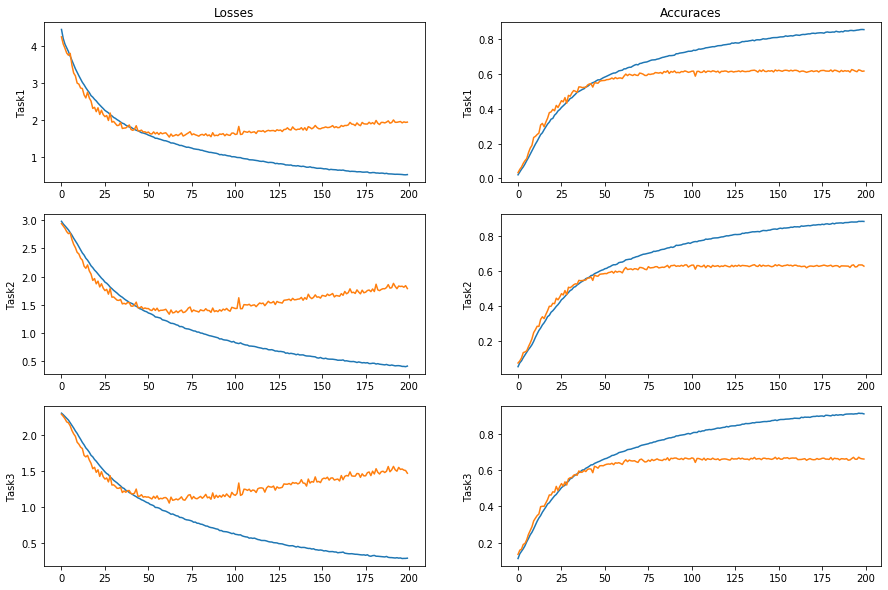

In [56]:
plot_results(train_metrics_task3, val_metrics_task3)
print_val_metrics(val_metrics_task3)

# TASK4

In [57]:
device = torch.device('cuda:0')

cnn = FourTaskCNN()
cnn = cnn.to(device)
optimizer = torch.optim.Adam(cnn.parameters())
criterion = nn.CrossEntropyLoss()

epoch_num = 200

In [58]:
# train task 2
def train_step(engine, batch):
    cnn.train()
    optimizer.zero_grad()
    images = batch[0].to(device)
    task1_labels = batch[1].to(device)
    task2_labels = batch[2].to(device)
    task3_labels = batch[3].to(device)
    task4_labels = batch[4].to(device)
    
    # forward propagation
    task1_pred, task2_pred, task3_pred, task4_pred = cnn(images)
    
    # loss computations
    task1_loss = criterion(task1_pred, task1_labels)
    task2_loss = criterion(task2_pred, task2_labels)
    task3_loss = criterion(task3_pred, task3_labels)
    task4_loss = criterion(task4_pred, task4_labels)

    total_task_loss = task1_loss + task2_loss + task3_loss + task4_loss

    # backpropagation
    total_task_loss.backward()
    optimizer.step()

    return task1_pred, task1_labels, task2_pred, task2_labels, task3_pred, task3_labels, task4_pred, task4_labels

def eval_step(engine, batch):
    cnn.eval()
    with torch.no_grad():
        images = batch[0].to(device)
        task1_labels = batch[1].to(device)
        task2_labels = batch[2].to(device)
        task3_labels = batch[3].to(device)
        task4_labels = batch[4].to(device)
    
        # forward propagation
        task1_pred, task2_pred, task3_pred, task4_pred = cnn(images)

    return task1_pred, task1_labels, task2_pred, task2_labels, task3_pred, task3_labels, task4_pred, task4_labels

# dataframes with logs
train_metrics_list = []
val_metrics_list = []

trainer = Engine(train_step)
validator = Engine(eval_step)

Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(trainer, 'Task1 Acc')
Accuracy(output_transform=lambda x: [x[2], x[3]]).attach(trainer, 'Task2 Acc')
Accuracy(output_transform=lambda x: [x[4], x[5]]).attach(trainer, 'Task3 Acc')
Accuracy(output_transform=lambda x: [x[6], x[7]]).attach(trainer, 'Task4 Acc')
Loss(criterion, output_transform=lambda x: [x[0], x[1]]).attach(trainer, 'Task1 Loss')
Loss(criterion, output_transform=lambda x: [x[2], x[3]]).attach(trainer, 'Task2 Loss')
Loss(criterion, output_transform=lambda x: [x[4], x[5]]).attach(trainer, 'Task3 Loss')
Loss(criterion, output_transform=lambda x: [x[6], x[7]]).attach(trainer, 'Task4 Loss')


Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(validator, 'Task1 Acc')
Accuracy(output_transform=lambda x: [x[2], x[3]]).attach(validator, 'Task2 Acc')
Accuracy(output_transform=lambda x: [x[4], x[5]]).attach(validator, 'Task3 Acc')
Accuracy(output_transform=lambda x: [x[6], x[7]]).attach(validator, 'Task4 Acc')
Loss(criterion, output_transform=lambda x: [x[0], x[1]]).attach(validator, 'Task1 Loss')
Loss(criterion, output_transform=lambda x: [x[2], x[3]]).attach(validator, 'Task2 Loss')
Loss(criterion, output_transform=lambda x: [x[4], x[5]]).attach(validator, 'Task3 Loss')
Loss(criterion, output_transform=lambda x: [x[6], x[7]]).attach(validator, 'Task4 Loss')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    print('##############################################')
    print('# Epoch {} completed in {:.2f} s'.format(engine.state.epoch, engine.state.times['EPOCH_COMPLETED']))
    
    val_metrics = validator.run(test_loader).metrics
    train_metrics = engine.state.metrics

    for key in train_metrics:
        print('# Training {}: {}'.format(key, train_metrics[key]))
    print('#')
    for key in train_metrics:
        print('# Vlaidation {}: {}'.format(key, val_metrics[key]))

    # save logs
    train_metrics_list.append(copy.deepcopy(train_metrics))
    val_metrics_list.append(copy.deepcopy(val_metrics))

In [29]:
output = trainer.run(data=train_loader, max_epochs=200)

##############################################
# Epoch 1 completed in 36.03 s
# Training Task1 Acc: 0.01668
# Training Task2 Acc: 0.05866
# Training Task3 Acc: 0.108
# Training Task4 Acc: 0.20452
# Training Task1 Loss: 4.493280557403565
# Training Task2 Loss: 2.9859101683044433
# Training Task3 Loss: 2.29909378036499
# Training Task4 Loss: 1.6099989739990235
#
# Vlaidation Task1 Acc: 0.0288
# Vlaidation Task2 Acc: 0.0663
# Vlaidation Task3 Acc: 0.1353
# Vlaidation Task4 Acc: 0.2338
# Vlaidation Task1 Loss: 4.336775573730469
# Vlaidation Task2 Loss: 2.956471173095703
# Vlaidation Task3 Loss: 2.288031057739258
# Vlaidation Task4 Loss: 1.6004998275756837


In [30]:
# make dataframe with metrics
train_metrics_task4 = pd.DataFrame(train_metrics_list)
val_metrics_task4 = pd.DataFrame(val_metrics_list)

train_metrics_task4.to_csv('train_metrics_task4.csv')
val_metrics_task4.to_csv('val_metrics_task4.csv')

Max Task1 acc: 0.0288 on epoch #0
Min Task1 loss: 4.336775573730469 on epoch #0

Max Task2 acc: 0.0663 on epoch #0
Min Task2 loss: 2.956471173095703 on epoch #0

Max Task3 acc: 0.1353 on epoch #0
Min Task3 loss: 2.288031057739258 on epoch #0

Max Task4 acc: 0.2338 on epoch #0
Min Task4 loss: 1.6004998275756837 on epoch #0



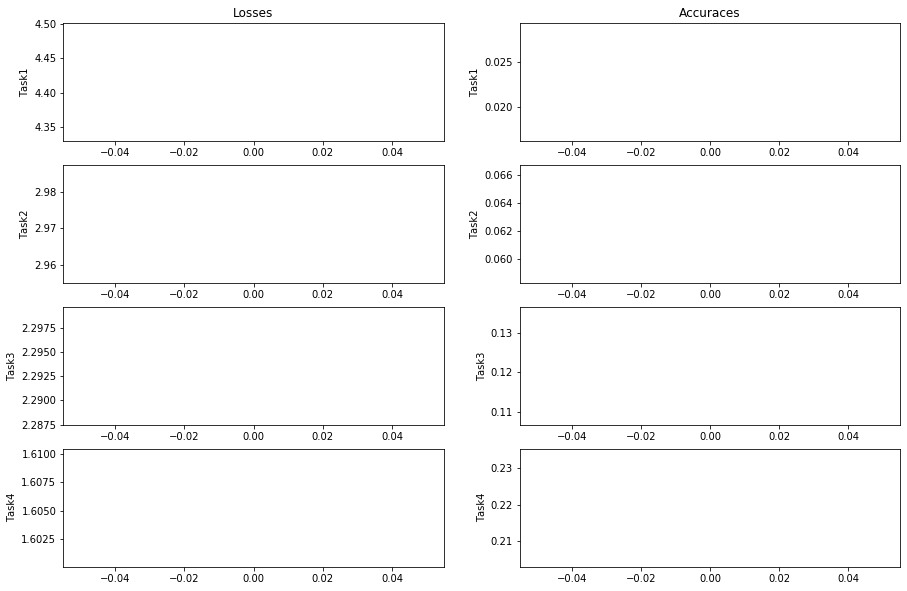

In [31]:
plot_results(train_metrics_task4, val_metrics_task4)
print_val_metrics(val_metrics_task4)

# TASK5

In [33]:
device = torch.device('cuda:0')

cnn = FiveTaskCNN()
cnn = cnn.to(device)
optimizer = torch.optim.Adam(cnn.parameters())
criterion = nn.CrossEntropyLoss()

epoch_num = 200

In [34]:
# train task 2
def train_step(engine, batch):
    cnn.train()
    optimizer.zero_grad()
    images = batch[0].to(device)
    task1_labels = batch[1].to(device)
    task2_labels = batch[2].to(device)
    task3_labels = batch[3].to(device)
    task4_labels = batch[4].to(device)
    task5_labels = batch[5].to(device)
    
    # forward propagation
    task1_pred, task2_pred, task3_pred, task4_pred, task5_pred = cnn(images)
    
    # loss computations
    task1_loss = criterion(task1_pred, task1_labels)
    task2_loss = criterion(task2_pred, task2_labels)
    task3_loss = criterion(task3_pred, task3_labels)
    task4_loss = criterion(task4_pred, task4_labels)
    task5_loss = criterion(task5_pred, task5_labels)

    total_task_loss = task1_loss + task2_loss + task3_loss + task4_loss + task5_loss

    # backpropagation
    total_task_loss.backward()
    optimizer.step()

    return task1_pred, task1_labels, task2_pred, task2_labels, task3_pred, task3_labels, task4_pred, task4_labels, task5_pred, task5_labels

def eval_step(engine, batch):
    cnn.eval()
    with torch.no_grad():
        images = batch[0].to(device)
        task1_labels = batch[1].to(device)
        task2_labels = batch[2].to(device)
        task3_labels = batch[3].to(device)
        task4_labels = batch[4].to(device)
        task5_labels = batch[5].to(device)
    
        # forward propagation
        task1_pred, task2_pred, task3_pred, task4_pred, task5_pred = cnn(images)

    return task1_pred, task1_labels, task2_pred, task2_labels, task3_pred, task3_labels, task4_pred, task4_labels, task5_pred, task5_labels

# dataframes with logs
train_metrics_list = []
val_metrics_list = []

trainer = Engine(train_step)
validator = Engine(eval_step)

Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(trainer, 'Task1 Acc')
Accuracy(output_transform=lambda x: [x[2], x[3]]).attach(trainer, 'Task2 Acc')
Accuracy(output_transform=lambda x: [x[4], x[5]]).attach(trainer, 'Task3 Acc')
Accuracy(output_transform=lambda x: [x[6], x[7]]).attach(trainer, 'Task4 Acc')
Accuracy(output_transform=lambda x: [x[8], x[9]]).attach(trainer, 'Task5 Acc')
Loss(criterion, output_transform=lambda x: [x[0], x[1]]).attach(trainer, 'Task1 Loss')
Loss(criterion, output_transform=lambda x: [x[2], x[3]]).attach(trainer, 'Task2 Loss')
Loss(criterion, output_transform=lambda x: [x[4], x[5]]).attach(trainer, 'Task3 Loss')
Loss(criterion, output_transform=lambda x: [x[6], x[7]]).attach(trainer, 'Task4 Loss')
Loss(criterion, output_transform=lambda x: [x[8], x[9]]).attach(trainer, 'Task5 Loss')


Accuracy(output_transform=lambda x: [x[0], x[1]]).attach(validator, 'Task1 Acc')
Accuracy(output_transform=lambda x: [x[2], x[3]]).attach(validator, 'Task2 Acc')
Accuracy(output_transform=lambda x: [x[4], x[5]]).attach(validator, 'Task3 Acc')
Accuracy(output_transform=lambda x: [x[6], x[7]]).attach(validator, 'Task4 Acc')
Accuracy(output_transform=lambda x: [x[8], x[9]]).attach(validator, 'Task5 Acc')
Loss(criterion, output_transform=lambda x: [x[0], x[1]]).attach(validator, 'Task1 Loss')
Loss(criterion, output_transform=lambda x: [x[2], x[3]]).attach(validator, 'Task2 Loss')
Loss(criterion, output_transform=lambda x: [x[4], x[5]]).attach(validator, 'Task3 Loss')
Loss(criterion, output_transform=lambda x: [x[6], x[7]]).attach(validator, 'Task4 Loss')
Loss(criterion, output_transform=lambda x: [x[8], x[9]]).attach(validator, 'Task5 Loss')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    print('##############################################')
    print('# Epoch {} completed in {:.2f} s'.format(engine.state.epoch, engine.state.times['EPOCH_COMPLETED']))
    
    val_metrics = validator.run(test_loader).metrics
    train_metrics = engine.state.metrics

    for key in train_metrics:
        print('# Training {}: {}'.format(key, train_metrics[key]))
    print('#')
    for key in train_metrics:
        print('# Vlaidation {}: {}'.format(key, val_metrics[key]))

    # save logs
    train_metrics_list.append(copy.deepcopy(train_metrics))
    val_metrics_list.append(copy.deepcopy(val_metrics))

In [35]:
output = trainer.run(data=train_loader, max_epochs=200)

##############################################
# Epoch 1 completed in 38.50 s
# Training Task1 Acc: 0.02004
# Training Task2 Acc: 0.0564
# Training Task3 Acc: 0.1102
# Training Task4 Acc: 0.2058
# Training Task5 Acc: 0.51444
# Training Task1 Loss: 4.442396118621827
# Training Task2 Loss: 2.9788456980133056
# Training Task3 Loss: 2.294570982589722
# Training Task4 Loss: 1.609484420852661
# Training Task5 Loss: 0.6933975746154785
#
# Vlaidation Task1 Acc: 0.0357
# Vlaidation Task2 Acc: 0.0707
# Vlaidation Task3 Acc: 0.1298
# Vlaidation Task4 Acc: 0.2295
# Vlaidation Task5 Acc: 0.5418
# Vlaidation Task1 Loss: 4.234868895721435
# Vlaidation Task2 Loss: 2.9448014404296874
# Vlaidation Task3 Loss: 2.278806834793091
# Vlaidation Task4 Loss: 1.5991306747436524
# Vlaidation Task5 Loss: 0.6874478845596314


In [36]:
# make dataframe with metrics
train_metrics_task5 = pd.DataFrame(train_metrics_list)
val_metrics_task5 = pd.DataFrame(val_metrics_list)

train_metrics_task5.to_csv('train_metrics_task5.csv')
val_metrics_task5.to_csv('val_metrics_task5.csv')

Max Task1 acc: 0.0357 on epoch #0
Min Task1 loss: 4.234868895721435 on epoch #0

Max Task2 acc: 0.0707 on epoch #0
Min Task2 loss: 2.9448014404296874 on epoch #0

Max Task3 acc: 0.1298 on epoch #0
Min Task3 loss: 2.278806834793091 on epoch #0

Max Task4 acc: 0.2295 on epoch #0
Min Task4 loss: 1.5991306747436524 on epoch #0

Max Task5 acc: 0.5418 on epoch #0
Min Task5 loss: 0.6874478845596314 on epoch #0



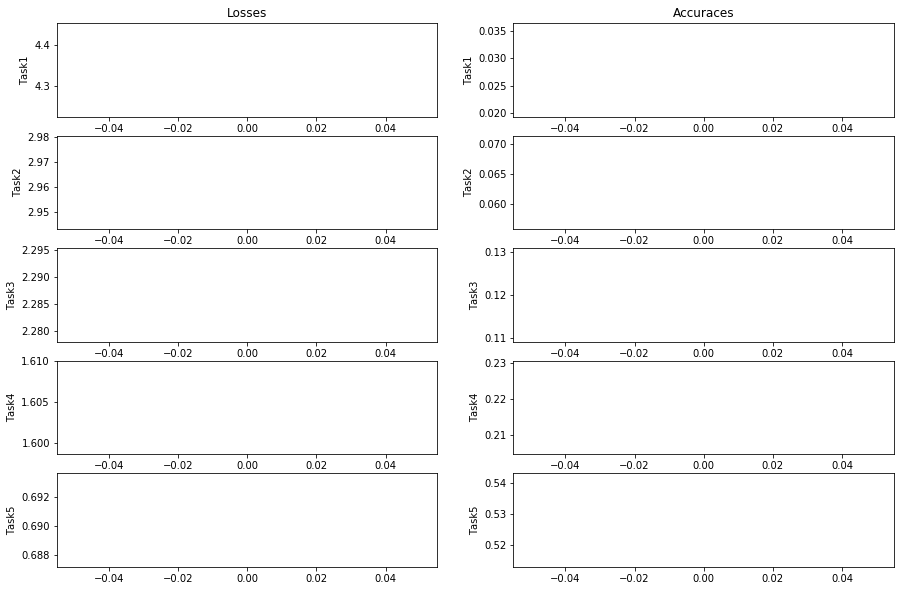

In [37]:
plot_results(train_metrics_task5, val_metrics_task5)
print_val_metrics(val_metrics_task5)